##Installing Dependencies

In [ ]:
!pip install datasets diffusers accelerate safetensors transformers pytorch-fid lpips torchmetrics[image] torch-fidelity

##Libraries

In [ ]:
import torch
from datasets import load_dataset
from diffusers import DiffusionPipeline
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics.image.fid import FrechetInceptionDistance
import lpips
import torchvision.transforms as T

##Loading Datasets

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading dataset...")
dataset = load_dataset("bryandts/robotwin-action-prediction-dataset", split="test")

Loading dataset...


Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

##Metric Calculation Functions

In [ ]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

def calculate_ssim(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    return ssim(img1_gray, img2_gray, data_range=255)

def calculate_lpips(img1, img2, lpips_model):
    preprocess = T.Compose([T.Resize((299, 299)), T.ToTensor()])
    img1_t = preprocess(img1).unsqueeze(0).to(device)
    img2_t = preprocess(img2).unsqueeze(0).to(device)
    return lpips_model(img1_t, img2_t).item()

def update_fid(fid_metric, img1, img2):
    preprocess = T.Compose([T.Resize((299, 299)), T.ToTensor()])
    img1 = preprocess(img1).unsqueeze(0).to(device).to(torch.uint8)
    img2 = preprocess(img2).unsqueeze(0).to(device).to(torch.uint8)
    fid_metric.update(img1, real=True)
    fid_metric.update(img2, real=False)

lpips_model = lpips.LPIPS(net='alex').to(device)
fid_metric = FrechetInceptionDistance(feature=64).to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


##Evaluation on Fine-Tuned Model

In [ ]:
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "bryandts/instruct-pix2pix-robotwin-action-finetuned"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionInstructPix2PixPipeline {
  "_class_name": "StableDiffusionInstructPix2PixPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "bryandts/instruct-pix2pix-robotwin-action-finetuned",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
import random
import numpy as np

# Set all random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Shuffle with fixed seed and select 100 samples
shuffled_dataset = dataset.shuffle(seed=seed)
sampled_dataset = shuffled_dataset.select(range(100))

Evaluation Loop

Evaluating on 100 samples...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

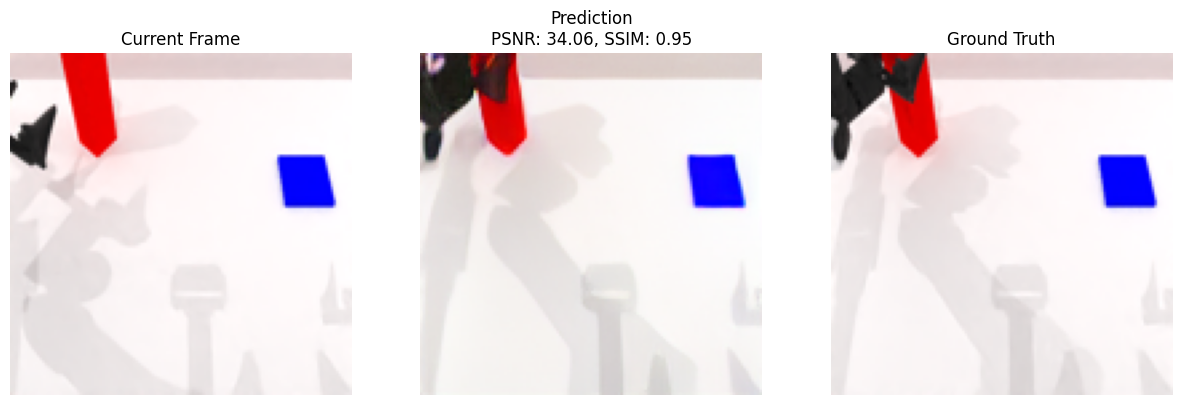

  1%|          | 1/100 [00:06<10:21,  6.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

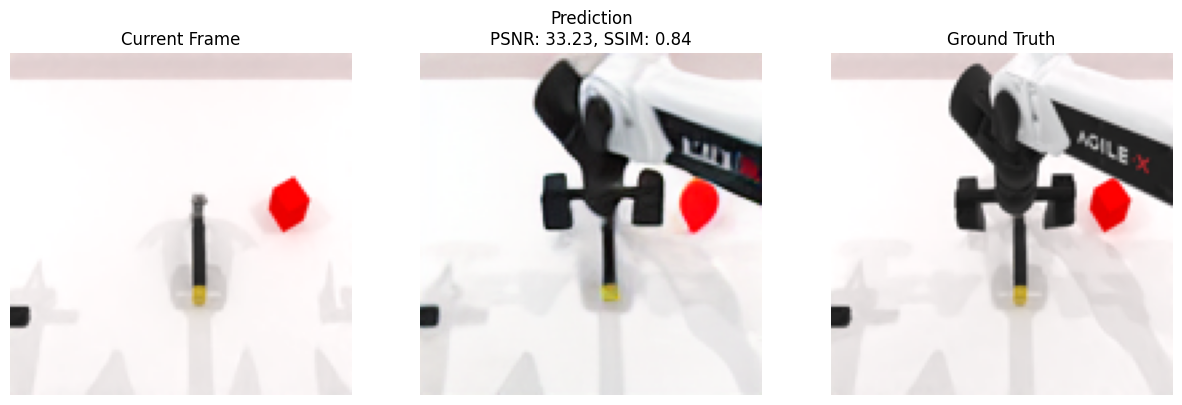

  2%|▏         | 2/100 [00:11<08:56,  5.48s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

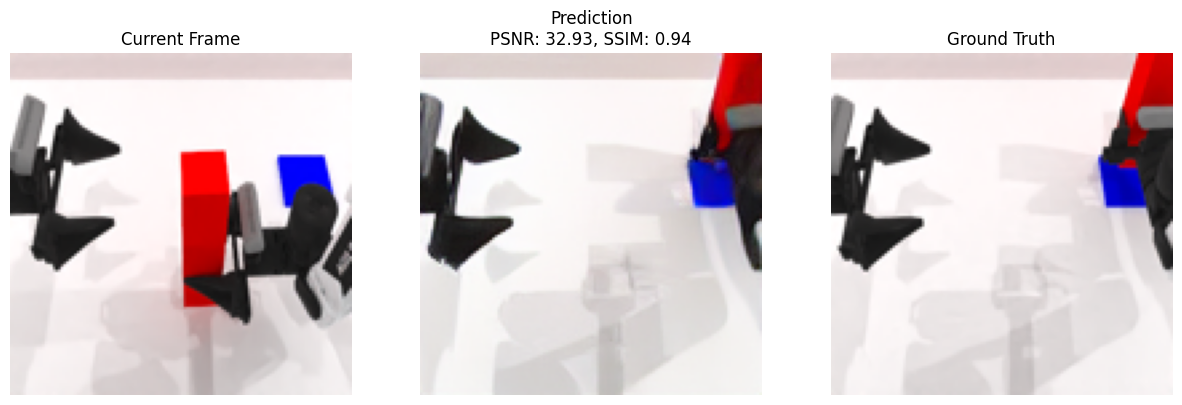

  3%|▎         | 3/100 [00:16<09:02,  5.60s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  4%|▍         | 4/100 [00:22<08:43,  5.45s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  5%|▌         | 5/100 [00:29<09:44,  6.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  6%|▌         | 6/100 [00:34<09:05,  5.80s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:40<09:05,  5.87s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:45<08:30,  5.55s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:50<08:05,  5.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:56<08:08,  5.43s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [01:00<07:46,  5.25s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [01:06<07:52,  5.37s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [01:11<07:32,  5.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [01:16<07:17,  5.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [01:21<07:30,  5.31s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [01:26<07:14,  5.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [01:32<07:19,  5.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [01:37<07:04,  5.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [01:42<06:51,  5.08s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [01:47<07:01,  5.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [01:52<06:46,  5.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [01:58<06:52,  5.29s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [02:03<06:37,  5.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [02:08<06:26,  5.08s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [02:13<06:33,  5.25s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [02:19<06:35,  5.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [02:25<06:39,  5.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [02:29<06:20,  5.29s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [02:35<06:13,  5.26s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 30%|███       | 30/100 [02:41<06:37,  5.68s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 31%|███       | 31/100 [02:46<06:14,  5.43s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 32%|███▏      | 32/100 [02:52<06:15,  5.52s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 33%|███▎      | 33/100 [02:57<05:55,  5.31s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 34%|███▍      | 34/100 [03:02<05:52,  5.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 35%|███▌      | 35/100 [03:07<05:43,  5.29s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 36%|███▌      | 36/100 [03:12<05:30,  5.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 37%|███▋      | 37/100 [03:18<05:34,  5.31s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 38%|███▊      | 38/100 [03:23<05:21,  5.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 39%|███▉      | 39/100 [03:28<05:21,  5.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 40%|████      | 40/100 [03:33<05:13,  5.23s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 41%|████      | 41/100 [03:38<05:02,  5.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 42%|████▏     | 42/100 [03:44<05:06,  5.29s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 43%|████▎     | 43/100 [03:49<04:53,  5.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 44%|████▍     | 44/100 [03:54<04:54,  5.26s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 45%|████▌     | 45/100 [03:59<04:44,  5.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 46%|████▌     | 46/100 [04:04<04:35,  5.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 47%|████▋     | 47/100 [04:10<04:39,  5.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 48%|████▊     | 48/100 [04:15<04:27,  5.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 49%|████▉     | 49/100 [04:20<04:29,  5.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 50%|█████     | 50/100 [04:25<04:19,  5.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 51%|█████     | 51/100 [04:30<04:09,  5.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 52%|█████▏    | 52/100 [04:36<04:14,  5.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 53%|█████▎    | 53/100 [04:41<04:03,  5.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 54%|█████▍    | 54/100 [04:46<04:05,  5.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 55%|█████▌    | 55/100 [04:51<03:53,  5.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 56%|█████▌    | 56/100 [04:56<03:44,  5.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 57%|█████▋    | 57/100 [05:02<03:46,  5.28s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 58%|█████▊    | 58/100 [05:07<03:37,  5.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 59%|█████▉    | 59/100 [05:12<03:38,  5.32s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 60%|██████    | 60/100 [05:17<03:29,  5.23s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 61%|██████    | 61/100 [05:22<03:21,  5.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 62%|██████▏   | 62/100 [05:28<03:22,  5.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 63%|██████▎   | 63/100 [05:33<03:13,  5.22s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 64%|██████▍   | 64/100 [05:39<03:14,  5.41s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 65%|██████▌   | 65/100 [05:44<03:04,  5.29s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 66%|██████▌   | 66/100 [05:49<02:58,  5.24s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 67%|██████▋   | 67/100 [05:55<02:54,  5.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 68%|██████▊   | 68/100 [05:59<02:45,  5.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 69%|██████▉   | 69/100 [06:05<02:45,  5.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 70%|███████   | 70/100 [06:10<02:36,  5.21s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 71%|███████   | 71/100 [06:15<02:30,  5.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 72%|███████▏  | 72/100 [06:21<02:27,  5.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 73%|███████▎  | 73/100 [06:26<02:19,  5.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 74%|███████▍  | 74/100 [06:31<02:19,  5.36s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 75%|███████▌  | 75/100 [06:37<02:13,  5.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 76%|███████▌  | 76/100 [06:43<02:12,  5.51s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 77%|███████▋  | 77/100 [06:48<02:04,  5.42s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 78%|███████▊  | 78/100 [06:53<01:57,  5.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 79%|███████▉  | 79/100 [06:59<01:53,  5.41s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 80%|████████  | 80/100 [07:03<01:45,  5.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 81%|████████  | 81/100 [07:09<01:42,  5.40s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 82%|████████▏ | 82/100 [07:14<01:35,  5.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 83%|████████▎ | 83/100 [07:20<01:30,  5.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 84%|████████▍ | 84/100 [07:25<01:25,  5.37s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 85%|████████▌ | 85/100 [07:30<01:19,  5.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 86%|████████▌ | 86/100 [07:36<01:16,  5.45s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 87%|████████▋ | 87/100 [07:41<01:09,  5.31s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 88%|████████▊ | 88/100 [07:47<01:05,  5.44s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 89%|████████▉ | 89/100 [07:52<00:58,  5.28s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 90%|█████████ | 90/100 [07:57<00:51,  5.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 91%|█████████ | 91/100 [08:02<00:48,  5.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 92%|█████████▏| 92/100 [08:07<00:41,  5.25s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 93%|█████████▎| 93/100 [08:13<00:37,  5.37s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 94%|█████████▍| 94/100 [08:18<00:31,  5.24s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 95%|█████████▌| 95/100 [08:23<00:25,  5.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 96%|█████████▌| 96/100 [08:29<00:21,  5.29s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 97%|█████████▋| 97/100 [08:33<00:15,  5.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 98%|█████████▊| 98/100 [08:39<00:10,  5.35s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 99%|█████████▉| 99/100 [08:44<00:05,  5.22s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [08:50<00:00,  5.30s/it]


In [ ]:
resolution=128
psnr_scores = []
ssim_scores = []
lpips_scores = []
num_samples = len(sampled_dataset)

print(f"Evaluating on {num_samples} samples...")
for i in tqdm(range(num_samples)):
    sample = sampled_dataset[i]

    # Get current frame and instruction
    current_frame = sample["current_frame"].resize((resolution, resolution)).convert("RGB")
    instruction = sample["instruction"]
    ground_truth = sample["future_frame"].resize((resolution, resolution)).convert("RGB")

    prediction = pipe(instruction, image=current_frame).images[0]

    # Convert images to numpy arrays for metrics calculation
    gt_array = np.array(ground_truth)
    pred_array = np.array(prediction)

    # Calculate metrics
    psnr = calculate_psnr(gt_array, pred_array)
    ssim_score = calculate_ssim(gt_array, pred_array)
    lpips_score = calculate_lpips(ground_truth, prediction, lpips_model)
    update_fid(fid_metric, ground_truth, prediction)

    psnr_scores.append(psnr)
    ssim_scores.append(ssim_score)
    lpips_scores.append(lpips_score)

    # Visualizing the first three examples
    if i < 3:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(current_frame)
        plt.title("Current Frame")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(prediction)
        plt.title(f"Prediction\nPSNR: {psnr:.2f}, SSIM: {ssim_score:.2f}")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth)
        plt.title("Ground Truth")
        plt.axis('off')

        plt.show()

# Calculate average metrics
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)
avg_lpips = np.mean(lpips_scores)
final_fid = fid_metric.compute().item()

In [ ]:
print(f"\nEvaluation Results on Finetuned Model:")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Average LPIPS: {avg_lpips:.4f}")
print(f"FID: {final_fid:.4f}")

results = {
    "psnr_scores": psnr_scores,
    "ssim_scores": ssim_scores,
    "lpips_scores": lpips_scores,
    "average_psnr": avg_psnr,
    "average_ssim": avg_ssim,
    "average_lpips": avg_lpips,
    "fid": final_fid,
}


Evaluation Results on Finetuned Model:
Average PSNR: 33.01 dB
Average SSIM: 0.8062
Average LPIPS: 0.1129
FID: 0.0010


## Evaluation on Pretrained Model

In [ ]:
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe_pretrained = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe_pretrained.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionInstructPix2PixPipeline {
  "_class_name": "StableDiffusionInstructPix2PixPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "timbrooks/instruct-pix2pix",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Evaluation Loop

Evaluating on 100 samples...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

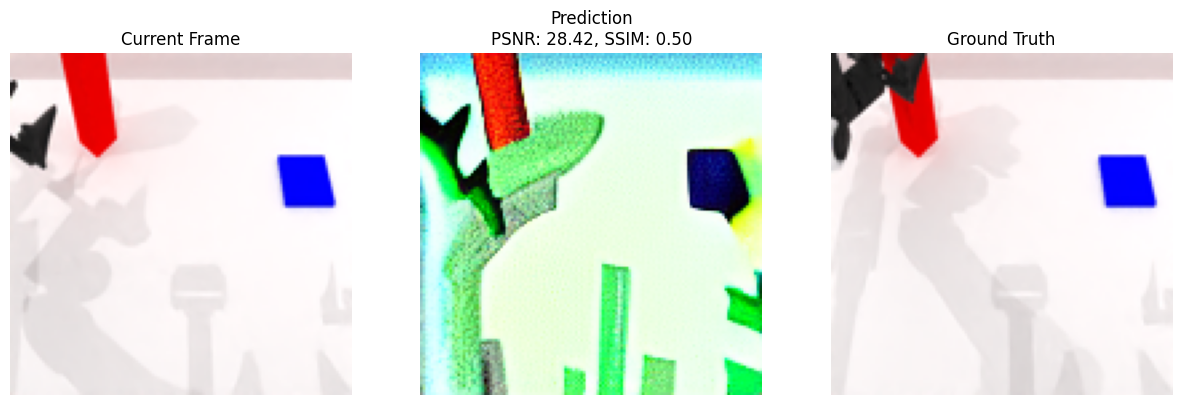

  1%|          | 1/100 [00:04<07:41,  4.66s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

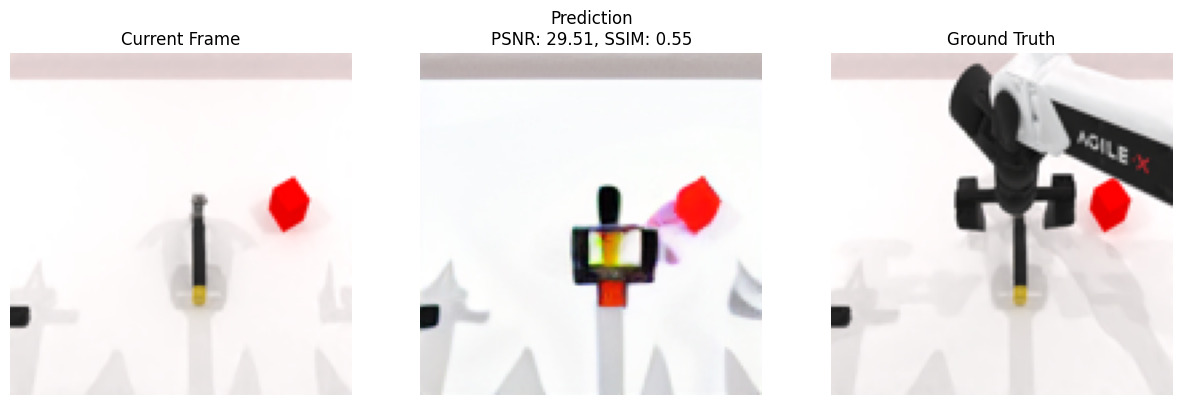

  2%|▏         | 2/100 [00:10<08:22,  5.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

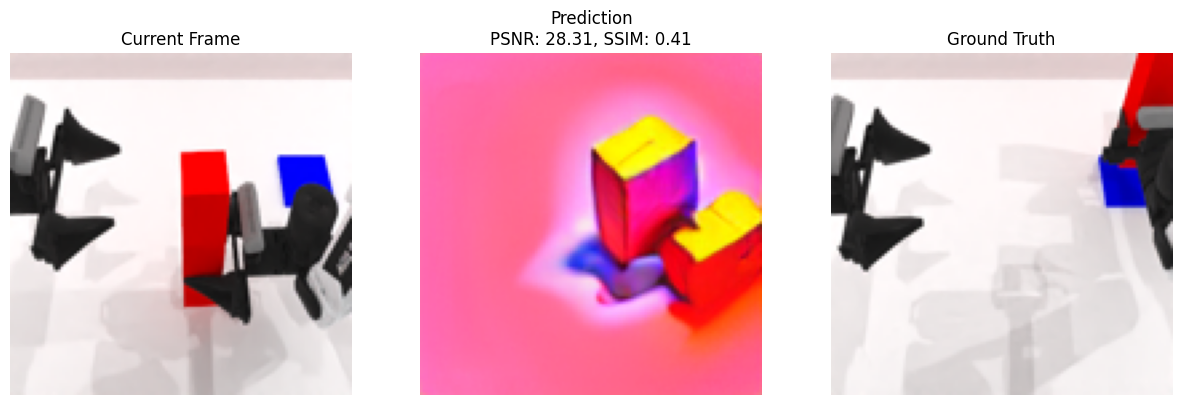

  3%|▎         | 3/100 [00:15<08:12,  5.08s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  4%|▍         | 4/100 [00:20<08:06,  5.07s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  5%|▌         | 5/100 [00:25<08:07,  5.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  6%|▌         | 6/100 [00:30<07:50,  5.00s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:35<08:02,  5.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:40<07:45,  5.06s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:45<07:39,  5.05s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:50<07:42,  5.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:55<07:27,  5.03s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [01:01<07:34,  5.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [01:05<07:19,  5.05s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [01:10<07:13,  5.04s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [01:16<07:14,  5.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [01:21<07:01,  5.02s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [01:26<07:09,  5.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [01:31<06:55,  5.06s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [01:36<06:47,  5.03s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [01:41<06:49,  5.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [01:46<06:36,  5.03s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [01:52<06:43,  5.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [01:56<06:29,  5.06s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [02:01<06:20,  5.00s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [02:07<06:25,  5.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [02:11<06:13,  5.04s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [02:17<06:20,  5.21s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [02:22<06:06,  5.08s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [02:27<05:54,  4.99s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 30%|███       | 30/100 [02:32<06:02,  5.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 31%|███       | 31/100 [02:37<05:49,  5.07s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 32%|███▏      | 32/100 [02:43<05:55,  5.23s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 33%|███▎      | 33/100 [02:47<05:41,  5.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 34%|███▍      | 34/100 [02:52<05:33,  5.06s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 35%|███▌      | 35/100 [02:58<05:40,  5.23s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 36%|███▌      | 36/100 [03:03<05:29,  5.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 37%|███▋      | 37/100 [03:09<05:34,  5.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 38%|███▊      | 38/100 [03:14<05:21,  5.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 39%|███▉      | 39/100 [03:19<05:15,  5.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 40%|████      | 40/100 [03:24<05:14,  5.25s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 41%|████      | 41/100 [03:29<05:02,  5.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 42%|████▏     | 42/100 [03:35<05:06,  5.28s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 43%|████▎     | 43/100 [03:39<04:54,  5.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 44%|████▍     | 44/100 [03:45<04:48,  5.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 45%|████▌     | 45/100 [03:50<04:48,  5.24s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 46%|████▌     | 46/100 [03:55<04:37,  5.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 47%|████▋     | 47/100 [04:01<04:40,  5.29s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 48%|████▊     | 48/100 [04:05<04:28,  5.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 49%|████▉     | 49/100 [04:11<04:24,  5.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 50%|█████     | 50/100 [04:16<04:23,  5.26s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 51%|█████     | 51/100 [04:21<04:13,  5.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 52%|█████▏    | 52/100 [04:27<04:16,  5.35s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 53%|█████▎    | 53/100 [04:32<04:05,  5.21s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 54%|█████▍    | 54/100 [04:37<04:02,  5.26s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 55%|█████▌    | 55/100 [04:42<03:56,  5.25s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 56%|█████▌    | 56/100 [04:47<03:46,  5.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 57%|█████▋    | 57/100 [04:53<03:48,  5.31s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 58%|█████▊    | 58/100 [04:58<03:37,  5.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 59%|█████▉    | 59/100 [05:03<03:33,  5.21s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 60%|██████    | 60/100 [05:08<03:29,  5.23s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 61%|██████    | 61/100 [05:13<03:20,  5.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 62%|██████▏   | 62/100 [05:19<03:21,  5.31s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 63%|██████▎   | 63/100 [05:24<03:12,  5.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 64%|██████▍   | 64/100 [05:29<03:09,  5.28s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 65%|██████▌   | 65/100 [05:35<03:03,  5.23s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 66%|██████▌   | 66/100 [05:39<02:54,  5.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 67%|██████▋   | 67/100 [05:45<02:54,  5.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 68%|██████▊   | 68/100 [05:50<02:45,  5.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 69%|██████▉   | 69/100 [05:56<02:45,  5.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 70%|███████   | 70/100 [06:01<02:36,  5.22s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 71%|███████   | 71/100 [06:06<02:29,  5.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 72%|███████▏  | 72/100 [06:11<02:29,  5.32s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 73%|███████▎  | 73/100 [06:16<02:20,  5.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 74%|███████▍  | 74/100 [06:22<02:18,  5.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 75%|███████▌  | 75/100 [06:27<02:10,  5.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 76%|███████▌  | 76/100 [06:32<02:02,  5.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 77%|███████▋  | 77/100 [06:38<02:02,  5.31s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 78%|███████▊  | 78/100 [06:42<01:54,  5.21s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 79%|███████▉  | 79/100 [06:48<01:52,  5.35s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 80%|████████  | 80/100 [06:53<01:44,  5.23s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 81%|████████  | 81/100 [06:58<01:37,  5.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 82%|████████▏ | 82/100 [07:04<01:35,  5.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 83%|████████▎ | 83/100 [07:09<01:28,  5.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 84%|████████▍ | 84/100 [07:14<01:25,  5.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 85%|████████▌ | 85/100 [07:19<01:18,  5.22s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 86%|████████▌ | 86/100 [07:24<01:12,  5.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 87%|████████▋ | 87/100 [07:30<01:08,  5.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 88%|████████▊ | 88/100 [07:35<01:02,  5.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 89%|████████▉ | 89/100 [07:41<00:58,  5.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 90%|█████████ | 90/100 [07:46<00:52,  5.22s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 91%|█████████ | 91/100 [07:51<00:46,  5.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 92%|█████████▏| 92/100 [07:56<00:42,  5.31s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 93%|█████████▎| 93/100 [08:01<00:36,  5.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 94%|█████████▍| 94/100 [08:07<00:32,  5.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 95%|█████████▌| 95/100 [08:12<00:26,  5.21s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 96%|█████████▌| 96/100 [08:17<00:20,  5.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 97%|█████████▋| 97/100 [08:22<00:15,  5.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 98%|█████████▊| 98/100 [08:27<00:10,  5.21s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 99%|█████████▉| 99/100 [08:33<00:05,  5.38s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [08:38<00:00,  5.19s/it]


In [ ]:
resolution=128
psnr_scores = []
ssim_scores = []
lpips_scores = []
num_samples = len(sampled_dataset)

print(f"Evaluating on {num_samples} samples...")
for i in tqdm(range(num_samples)):
    sample = sampled_dataset[i]

    # Get current frame and instruction
    current_frame = sample["current_frame"].resize((resolution, resolution)).convert("RGB")
    instruction = sample["instruction"]
    ground_truth = sample["future_frame"].resize((resolution, resolution)).convert("RGB")

    prediction = pipe_pretrained(instruction, image=current_frame).images[0]

    # Convert images to numpy arrays for metrics calculation
    gt_array = np.array(ground_truth)
    pred_array = np.array(prediction)

    # Calculate metrics
    psnr = calculate_psnr(gt_array, pred_array)
    ssim_score = calculate_ssim(gt_array, pred_array)
    lpips_score = calculate_lpips(ground_truth, prediction, lpips_model)
    update_fid(fid_metric, ground_truth, prediction)

    psnr_scores.append(psnr)
    ssim_scores.append(ssim_score)
    lpips_scores.append(lpips_score)

    # Visualing the first three examples
    if i < 3:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(current_frame)
        plt.title("Current Frame")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(prediction)
        plt.title(f"Prediction\nPSNR: {psnr:.2f}, SSIM: {ssim_score:.2f}")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth)
        plt.title("Ground Truth")
        plt.axis('off')

        plt.show()

# Calculate average metrics
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)
avg_lpips = np.mean(lpips_scores)
final_fid = fid_metric.compute().item()

In [ ]:
print(f"\nEvaluation Results on Pretrained Model:")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Average LPIPS: {avg_lpips:.4f}")
print(f"FID: {final_fid:.4f}")

# Save results
results = {
    "psnr_scores": psnr_scores,
    "ssim_scores": ssim_scores,
    "lpips_scores": lpips_scores,
    "average_psnr": avg_psnr,
    "average_ssim": avg_ssim,
    "average_lpips": avg_lpips,
    "fid": final_fid,
}


Evaluation Results on Pretrained Model:
Average PSNR: 28.85 dB
Average SSIM: 0.4476
Average LPIPS: 0.5193
FID: 0.0024
